### MOOC-HPFEM: Template notebook to be used to complete the assignments



The present notebook is meant to be a template for you to use while doing the assignments of the course. The first cell is meant to be run as-is and takes care of configuring the environment for you. The second cell is empty by default and is where you are supposed to paste the code you are given in the assignments so that you can modify and run it.

### FEniCS DFS formulation to run and modify yourself

In [0]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 

def plot_compact(u, t, stepcounter, QQ, pl, ax, soltit = "Velocity"): # Compact plot utility function
  if stepcounter == 0:
    pl, ax = plt.subplots(); display(pl); clear_output(); # Plotting setup
  if stepcounter % 5 == 0:
    #u.set_allow_extrapolation(True)
    uEuclidnorm = project(sqrt(inner(u, u)), QQ)
    ax.cla()
    fig = plt.gcf()
    fig.set_size_inches(16, 4)
    plt.subplot(1, 2, 1)
    pp = plot(uEuclidnorm, cmap="coolwarm")
    plt.title("%s at t=%f" % (soltit, t)) # Plot norm of solution
    if t == 0:
      plt.axis(G)
      plt.colorbar(pp, shrink=0.5)
    plt.subplot(1, 2, 2);
    if t == 0:
      plot(QQ.mesh())
      plt.title("Mesh") # Plot mesh
    plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)

def plot_compact_static(u, QQ, label = "Velocity"): # Compact plot utility function
  pl, ax = plt.subplots();
  uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
  plt.subplot(1, 2, 1); pp = plot(uEuclidnorm, cmap="coolwarm"); plt.title("%s" % (label)) # Plot norm of velocity
  plt.axis(G); plt.colorbar(pp, shrink=0.5); 
  plt.subplot(1, 2, 2);
  plot(QQ.mesh()); plt.title("Mesh") # Plot mesh
  plt.tight_layout(); dpl = display(pl, display_id="test");
  
  return (pl, ax)



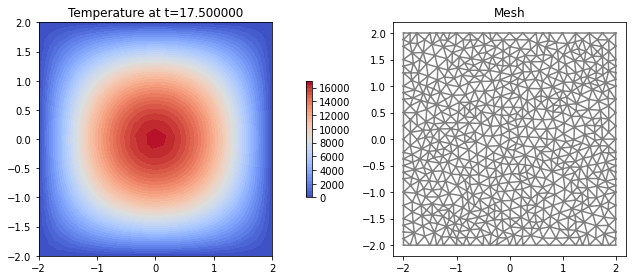

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


elapsed CPU time 9.426813999999993


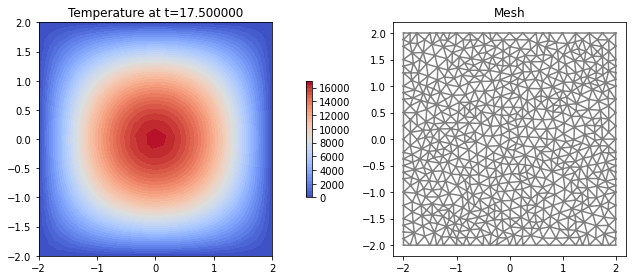

In [12]:
# Define domain and mesh
XMIN, XMAX = -2., 2.; 
YMIN, YMAX = -2., 2.; 
G = [XMIN, XMAX, YMIN, YMAX];
mresolution = 20;
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])), mresolution)

# Define finite element function space
degree = 1;
V = FunctionSpace(mesh, "CG", degree);

# Finite element functions
v = TestFunction(V); 
u = Function(V);

# Define boundary conditions
def boundary(x, on_boundary):
    return on_boundary

# Time parameters
theta = 1.0 # Implicit Euler
k = 0.5; # Time step
t, T = 0., 20.; # Start and end time

k_coeff = 1 
ue = Expression('exp(-(x[0]*x[0] + x[1]*x[1])/(4*a*t)) / (4*pi*a*t)',a=k_coeff,t=1e-7,degree=degree,domain=mesh)
u0 = ue

bc = DirichletBC(V,ue,boundary) 

pl , ax = None , None 
stepcounter = 0 
timer0 = time.clock() 

while t<T:
  um = theta*u + (1.0-theta)*u0 
  r = (u-u0)/k*v*dx + k_coeff*inner(grad(um),grad(v))*dx

  solve(r==0,u,bc) 

  pl , ax = plot_compact(u,t,stepcounter,V,pl,ax,soltit = "Temperature")

  t += k 
  u0 = project(u,V) 
  stepcounter += 1 

print('elapsed CPU time',(time.clock() - timer0)) 